<h1> Collect Job Post Data </h1>
<p> Given a query, find applicable Indeed.com posts </p>

In [89]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import httpx
import re
import json
import time
# import datatime

Uses "data scientist" and "Santa Clara" as default query fields. 
Make a request mimicking the behavior of a browser request.

In [ ]:

# query = input("Enter your job query: ")
# location = input("Enter your location: ")
query = "data scientist"
location = "Santa Clara"

# process query 
words_query = query.split()
processed_query = "+".join(words_query)

# use this to get it to work on all locations
processed_location = requests.utils.quote(location)

# Add headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    # "Accept-Encoding": "gzip, deflate, br",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    # "Connection": "keep-alive",
    "Referer": "https://www.indeed.com/",
}

# make the url
URL = f"https://www.indeed.com/jobs?q={processed_query}&l={processed_location}"

# request and parse
response = requests.get(URL, headers=headers, timeout=10)
response.raise_for_status()

print(URL)


https://www.indeed.com/jobs?q=data+scientist&l=Santa%20Clara


Add all of the job search results into a Dataframe**

```python
all_jobs = {
    Title: the job title/position,
    Company Name: the company name of the job post
    Location: the location information of the job post
    Link: the redirection link to get more details of the job
}

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import requests # Assuming requests is imported elsewhere

# Initialize all_jobs as an empty LIST of dictionaries
all_jobs = [] 
default_indeed_url = "https://www.indeed.com"

try:
    # Initialize soup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Get basic job information for each job card
    company_names = soup.find_all(attrs={"data-testid": "company-name"})
    text_location = soup.find_all(attrs={"data-testid": "text-location"})
    
    # set total size of jobs
    max_jobs = max(len(company_names), len(text_location))

    # Fill in the company name/text location first
    for i in range(max_jobs):
        company_name = company_names[i].get_text(strip=True) if i < len(company_names) else 'N/A'
        location = text_location[i].get_text(strip=True) if i < len(text_location) else 'N/A'
        
        # Create a new dictionary for each job and append it to the list
        all_jobs.append({
            "Title": 'N/A', # Placeholder 
            "Location": location,
            "Company Name": company_name, 
            "Link": 'N/A', # Placeholder 
        })
        
    # Check for CAPTCHA/blocking page
    if "captcha" in response.text.lower() or "not found" in soup.title.text.lower():
         print("CAPTCHA or Block detected. The scraping attempt was blocked.")
    else:
        # Get Title and Link (Update Existing Job Cards) ---
        job_links = soup.find_all('a', class_='jcs-JobTitle')
        
        # We assume job_links corresponds to the records in all_jobs by index
        for i, title_element in enumerate(job_links):
            if i >= len(all_jobs):
                print(f"Warning: Found more links ({len(job_links)}) than initial records ({len(all_jobs)}).")
                break
                
            # Extract the Title from the span's 'title' attribute
            title_span = title_element.find("span")
            raw_title = title_span.get("title") if title_span else 'N/A'
            # print("title_element: ", title_element)
            
            # Extract the Link (partial path)
            indiv_link = title_element.get('href')
            full_link = default_indeed_url + indiv_link
            
            # Update the corresponding dictionary in the all_jobs list
            all_jobs[i]['Title'] = raw_title
            all_jobs[i]['Link'] = full_link
            

    # Put into dataframe
    df_jobs = pd.DataFrame(all_jobs)
    
    print(f"Total jobs successfully parsed: {len(df_jobs)}")
    
except requests.exceptions.HTTPError as e:
    print(f"\nHTTP Error (Status Code {e.response.status_code}): The server definitively blocked the request.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    
df_jobs

title_element:  <a aria-label="full details of Data Scientist" class="jcs-JobTitle css-1baag51 eu4oa1w0" data-hide-spinner="true" data-hiring-event="false" data-jk="78e6280457103317" data-mobtk="1jb4q3411gqlp88m" href="/rc/clk?jk=78e6280457103317&amp;bb=Nm8sqwyT04Wia_3UsmYCTYA7U8sa7KpzE8QPHEHXPeaGvaSwoLGtdppyXdLYnSc7glFAIdWno8-KWwMm_wZ2-CzCV66aIs0Wft-gULfdlggrY9wNLNEmb9HkhkkkY2RqGSajWNKOkLWcIWQPOC46IQ%3D%3D&amp;xkcb=SoDa67M3qk8DXQADNr0LbzkdCdPP&amp;fccid=fa5bbc12d1498bc0&amp;vjs=3" id="job_78e6280457103317" role="button"><span id="jobTitle-78e6280457103317" title="Data Scientist">Data Scientist</span></a>
title_element:  <a aria-label="full details of Data Scientist" class="jcs-JobTitle css-1baag51 eu4oa1w0" data-hide-spinner="true" data-hiring-event="false" data-jk="a4f3e98fa98cb261" data-mobtk="1jb4q3411gqlp88m" href="/rc/clk?jk=a4f3e98fa98cb261&amp;bb=Nm8sqwyT04Wia_3UsmYCTaqJ-mbPN_BVFqrz3E2p8PjK-eNtzKwWpgU2Ffe75aPOJXm6gCXmLyYTG8P-3MKpvFU9Pp77w5VjPdf0KcQ0w7P__6kQHMmQjNW9J7dtfeCjTimGA

,Title,Location,Company Name,Link
0,Data Scientist,"Pleasanton, CA 94566",Sajix Software Solution Private Limited,https://www.indeed.com/rc/clk?jk=78e6280457103...
1,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/rc/clk?jk=a4f3e98fa98cb...
2,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/viewjob?jk=cdef01234567...
3,Data Scientist (Tapestry),"Mountain View, CA",Loon,https://www.indeed.com/rc/clk?jk=8bb8e7ae29b53...
4,"Research Scientist, Foundation Model (LLM)","San Jose, CA",ByteDance,https://www.indeed.com/rc/clk?jk=780362905ef9d...
5,Data Scientist,"Santa Clara, CA",NutaNXT Technologies,https://www.indeed.com/rc/clk?jk=2ad5b66e52509...
6,"Data Scientist (Dublin, CA)","Hybrid work in Dublin, CA 94568",SavvyMoney,https://www.indeed.com/rc/clk?jk=f33e369c31172...
7,Machine Learning Engineer,"Hybrid work in Santa Clara, CA 95050",Edurech Technoogy,https://www.indeed.com/rc/clk?jk=54d0e2fb38ac1...
8,Data Scientist,"Hybrid work in Pleasanton, CA 94566",Flex Employee Services,https://www.indeed.com/rc/clk?jk=18dd050faef8e...
9,Machine Learning Engineer,"Santa Clara, CA",Amiri Recruiting,https://www.indeed.com/rc/clk?jk=674087e716231...


Find more detailed job descriptions by vising the individual links visited.

In [ ]:
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd # Assuming you're using this

# Define Robust Headers (Crucial for Indeed) 
# Use a strong, updated User-Agent and a Referer

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36",
    "Referer": URL, 
    "Accept-Language": "en-US,en;q=0.9",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
}

# Initialize a Session
session = requests.Session()
session.headers.update(HEADERS)

# Iterate and Request
successful_details = 0
failed_details = 0

for i, job in enumerate(all_jobs):
    url = job.get("Link")
    job_title = job.get("Title", "Unknown Job")

    print(f"\n--- Processing Job {i+1}: {job_title} ---")
    print(f"URL Type: {'viewjob' if '/viewjob?' in url else 'redirect'}")
    
    try:
        # from /rc/clk? and /pagead/clk? to the final /viewjob? page.
        
        response = session.get(url, timeout=15)
        response.raise_for_status() # Raise exception for 4xx or 5xx status codes
        
        # Anti-Scraping Check ---
        if "captcha" in response.text.lower() or "not found" in BeautifulSoup(response.text, 'html.parser').title.text.lower():
             print("CAPTCHA/Block detected or Job Not Found. Skipping details extraction.")
             failed_details += 1
             job['Description'] = 'BLOCKED/NOT FOUND'
             continue
        
        # Success: Proceed to Scrape Details ---
        
        # Parse the details page HTML
        detail_soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the job description container (this class is correct for detail pages)
        description_container = detail_soup.find('div', class_='jobsearch-JobComponent-description')
        
        if description_container:
            full_description = description_container.get_text('\n', strip=True)
            job['Description'] = full_description
            successful_details += 1
            print(f"Successfully extracted details for {job_title}. Description length: {len(full_description)} chars.")
        else:
            print("Description container not found on the detail page (likely a complex redirect or missing content).")
            failed_details += 1
            job['Description'] = 'CONTAINER MISSING'


    except requests.exceptions.RequestException as e:
        print(f"Request Failed for {job_title}: {e}")
        failed_details += 1
        job['Description'] = f'REQUEST ERROR: {e}'
        
    finally:
        # Wait between 2 and 5 seconds to reduce rate-limiting risk.
        delay = 3
        print(f"Waiting for {delay} seconds before next request...")
        time.sleep(delay) 

print(f"\n\n--- Summary ---")
print(f"Total jobs processed: {len(all_jobs)}")
print(f"Successful details extracted: {successful_details}")
print(f"Failed/Blocked requests: {failed_details}")


--- Processing Job 1: Data Scientist ---
URL Type: redirect
Successfully extracted details for Data Scientist. Description length: 2885 chars.
Waiting for 3 seconds before next request...

--- Processing Job 2: Data Scientist ---
URL Type: redirect
Successfully extracted details for Data Scientist. Description length: 2892 chars.
Waiting for 3 seconds before next request...

--- Processing Job 3: Data Scientist ---
URL Type: viewjob
Request Failed for Data Scientist: 404 Client Error: Not Found for url: https://www.indeed.com/viewjob?jk=cdef0123456789ab
Waiting for 3 seconds before next request...

--- Processing Job 4: Data Scientist (Tapestry) ---
URL Type: redirect
Successfully extracted details for Data Scientist (Tapestry). Description length: 6140 chars.
Waiting for 3 seconds before next request...

--- Processing Job 5: Research Scientist, Foundation Model (LLM) ---
URL Type: redirect
Successfully extracted details for Research Scientist, Foundation Model (LLM). Description len

Create a master dataframe that includes the new description text

```python
all_jobs = {
    Title: the job title/position,
    Company Name: the company name of the job post
    Location: the location information of the job post
    Link: the redirection link to get more details of the job
    Description: the raw text of the job description
}
```

Record this into the json file, to minimize requests. 

In [100]:
final_df = pd.DataFrame(all_jobs)

output_filename = 'indeed_job_data_sample.json'

try:
    final_df.to_json(
        output_filename, 
        orient='records',
        lines=False, 
        indent=4    
    )
    print(f"\nSuccessfully saved {len(df_jobs)} records to {output_filename}")
    
except Exception as e:
    print(f"\n Error saving JSON file: {e}")

final_df


Successfully saved 16 records to indeed_job_data_sample.json


,Title,Location,Company Name,Link,Description
0,Data Scientist,"Pleasanton, CA 94566",Sajix Software Solution Private Limited,https://www.indeed.com/rc/clk?jk=78e6280457103...,Profile insights\nFind out how your skills ali...
1,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/rc/clk?jk=a4f3e98fa98cb...,Profile insights\nFind out how your skills ali...
2,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/viewjob?jk=cdef01234567...,REQUEST ERROR: 404 Client Error: Not Found for...
3,Data Scientist (Tapestry),"Mountain View, CA",Loon,https://www.indeed.com/rc/clk?jk=8bb8e7ae29b53...,Profile insights\nFind out how your skills ali...
4,"Research Scientist, Foundation Model (LLM)","San Jose, CA",ByteDance,https://www.indeed.com/rc/clk?jk=780362905ef9d...,Profile insights\nFind out how your skills ali...
5,Data Scientist,"Santa Clara, CA",NutaNXT Technologies,https://www.indeed.com/rc/clk?jk=2ad5b66e52509...,Profile insights\nFind out how your skills ali...
6,"Data Scientist (Dublin, CA)","Hybrid work in Dublin, CA 94568",SavvyMoney,https://www.indeed.com/rc/clk?jk=f33e369c31172...,Profile insights\nFind out how your skills ali...
7,Machine Learning Engineer,"Hybrid work in Santa Clara, CA 95050",Edurech Technoogy,https://www.indeed.com/rc/clk?jk=54d0e2fb38ac1...,Profile insights\nFind out how your skills ali...
8,Data Scientist,"Hybrid work in Pleasanton, CA 94566",Flex Employee Services,https://www.indeed.com/rc/clk?jk=18dd050faef8e...,Profile insights\nFind out how your skills ali...
9,Machine Learning Engineer,"Santa Clara, CA",Amiri Recruiting,https://www.indeed.com/rc/clk?jk=674087e716231...,Profile insights\nFind out how your skills ali...


Extract some keywords using REGEX

In [ ]:
import re
import pandas as pd
import time
import random

# --- List of all relevant headers to look for ---
HEADER_PHRASES = [
    'Minimum Qualifications', 'Qualifications', 'Requirements', 'What You Bring',
    'Key Responsibilities', 'Responsibilities', 'Job Duties', 'Your Role'
]

# Map multiple phrases to single standardized column names
NORMALIZED_KEYS = {
    'QUALIFICATIONS': 'Qualifications', 
    'REQUIREMENTS': 'Qualifications', 
    'MINIMUM QUALIFICATIONS': 'Qualifications',
    'MINIMUM REQUIREMENTS': 'Qualifications',
    'WHAT YOU BRING': 'Qualifications',
    'KEY RESPONSIBILITIES': 'Responsibilities', 
    'RESPONSIBILITIES': 'Responsibilities',
    'JOB DUTIES': 'Responsibilities',
    'YOUR ROLE': 'Responsibilities',
}

def extract_key_terms_by_header(description_text):
    """
    Finds key section headers in the description and extracts the content 
    that immediately follows until the next header or the end of the text.
    """
    extracted_sections = {}
    
    if not description_text or description_text == 'N/A' or description_text.startswith('BLOCKED'):
        return extracted_sections

    # Regex to find the headers, match the header text
    # The '|' joins the headers to search for any of them.
    HEADER_PATTERN = r'(' + '|'.join([re.escape(h) for h in HEADER_PHRASES]) + r')\s*:?\s*\n'
    
    # Use finditer to find the start and end positions of all headers
    matches = list(re.finditer(HEADER_PATTERN, description_text, re.IGNORECASE))
    
    if not matches:
        return extracted_sections

    for i, match in enumerate(matches):
        # The raw header text (e.g., 'Key Responsibilities')
        header_text = match.group(1).upper().strip() 
        start_index = match.end() # Start capturing content AFTER the header match

        # Determine the end of the section (start of the next header or end of document)
        if i + 1 < len(matches):
            end_index = matches[i+1].start()
        else:
            end_index = len(description_text)
            
        content = description_text[start_index:end_index].strip()
        
        # Normalize the header name
        normalized_key = next((v for k, v in NORMALIZED_KEYS.items() if k in header_text), None)

        if normalized_key and content and len(content) > 10:
            # If the key already exists (e.g., both "Qualifications" and "Requirements" are present), join the content
            if normalized_key in extracted_sections:
                extracted_sections[normalized_key] += "\n\n" + content
            else:
                extracted_sections[normalized_key] = content

    return extracted_sections


# Main Loop to Populate the new DataFrame

key_terms_list = []

# Assuming 'all_jobs' is the list of dictionaries containing 'Title', 'Link', and 'Description'
for job in all_jobs:
    # 1. Extract the sections from the description text
    extracted_sections = extract_key_terms_by_header(job.get('Description', ''))
    
    # 2. Create a new dictionary entry for the key_terms DataFrame
    key_terms_entry = {
        'Title': job.get('Title', 'N/A'),        
        'Link': job.get('Link', 'N/A'),
        'Qualifications': extracted_sections.get('Qualifications', ''),
        'Responsibilities': extracted_sections.get('Responsibilities', ''),
    }
    
    key_terms_list.append(key_terms_entry)

key_terms_df = pd.DataFrame(key_terms_list)

key_terms_df

,Title,Link,Qualifications,Responsibilities
0,Data Scientist,https://www.indeed.com/rc/clk?jk=78e6280457103...,"Bachelor’s or Master’s in Computer Science, St...",Assist in cleaning and preprocessing structure...
1,Data Scientist,https://www.indeed.com/rc/clk?jk=a4f3e98fa98cb...,"Bachelor’s or Master’s in Computer Science, St...",Assist in cleaning and preprocessing structure...
2,Data Scientist,https://www.indeed.com/viewjob?jk=cdef01234567...,,
3,Data Scientist (Tapestry),https://www.indeed.com/rc/clk?jk=8bb8e7ae29b53...,,
4,"Research Scientist, Foundation Model (LLM)",https://www.indeed.com/rc/clk?jk=780362905ef9d...,"1. Excellent coding ability, data structures, ...",With a long-term vision and a strong commitmen...
5,Data Scientist,https://www.indeed.com/rc/clk?jk=2ad5b66e52509...,Self-starter with good communication skills\nP...,Extract data from multiple data sources like M...
6,"Data Scientist (Dublin, CA)",https://www.indeed.com/rc/clk?jk=f33e369c31172...,,Perform exploratory and statistical data analy...
7,Machine Learning Engineer,https://www.indeed.com/rc/clk?jk=54d0e2fb38ac1...,,"Design, develop, and implement machine learnin..."
8,Data Scientist,https://www.indeed.com/rc/clk?jk=18dd050faef8e...,"Bachelor’s or Master’s in Computer Science, Da...",Design and implement ETL/ELT pipelines using D...
9,Machine Learning Engineer,https://www.indeed.com/rc/clk?jk=674087e716231...,,


<h3>High-Level Skillsets</h3>

Bag of Words Creation

In [36]:
import json
import pandas as pd

# Load previously saved data (skip scraping)
with open('indeed_job_data_sample.json', 'r') as f:
    all_jobs = json.load(f)

print(f"Loaded {len(all_jobs)} jobs from JSON")

# Create dataframe for reference
df_jobs = pd.DataFrame(all_jobs)
df_jobs

Loaded 16 jobs from JSON


,Title,Location,Company Name,Link,Description
0,Data Scientist,"Pleasanton, CA 94566",Sajix Software Solution Private Limited,https://www.indeed.com/rc/clk?jk=78e6280457103...,Profile insights\nFind out how your skills ali...
1,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/rc/clk?jk=a4f3e98fa98cb...,Profile insights\nFind out how your skills ali...
2,Data Scientist,"Pleasanton, CA 94566",Sajix,https://www.indeed.com/viewjob?jk=cdef01234567...,REQUEST ERROR: 404 Client Error: Not Found for...
3,Data Scientist (Tapestry),"Mountain View, CA",Loon,https://www.indeed.com/rc/clk?jk=8bb8e7ae29b53...,Profile insights\nFind out how your skills ali...
4,"Research Scientist, Foundation Model (LLM)","San Jose, CA",ByteDance,https://www.indeed.com/rc/clk?jk=780362905ef9d...,Profile insights\nFind out how your skills ali...
5,Data Scientist,"Santa Clara, CA",NutaNXT Technologies,https://www.indeed.com/rc/clk?jk=2ad5b66e52509...,Profile insights\nFind out how your skills ali...
6,"Data Scientist (Dublin, CA)","Hybrid work in Dublin, CA 94568",SavvyMoney,https://www.indeed.com/rc/clk?jk=f33e369c31172...,Profile insights\nFind out how your skills ali...
7,Machine Learning Engineer,"Hybrid work in Santa Clara, CA 95050",Edurech Technoogy,https://www.indeed.com/rc/clk?jk=54d0e2fb38ac1...,Profile insights\nFind out how your skills ali...
8,Data Scientist,"Hybrid work in Pleasanton, CA 94566",Flex Employee Services,https://www.indeed.com/rc/clk?jk=18dd050faef8e...,Profile insights\nFind out how your skills ali...
9,Machine Learning Engineer,"Santa Clara, CA",Amiri Recruiting,https://www.indeed.com/rc/clk?jk=674087e716231...,Profile insights\nFind out how your skills ali...


TF-IDF Analysis


In [ ]:
# pip install mlxtend

  Using cached mlxtend-0.23.4-py3-none-any.whl (1.4 MB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_10_9_x86_64.whl (12.1 MB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [63]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Custom stop words for job postings
custom_stop_words = [
    'job', 'jobs', 'experience', 'skills', 'skill', 'work', 'working',
    'description', 'job description', 'nbsp', 'team', 'time', 'company',
    'role', 'position', 'years', 'year', 'ability', 'strong', 'good',
    'excellent', 'required', 'preferred', 'looking', 'seeking', 'apply',
    'candidate', 'candidates', 'qualifications', 'requirements', 'responsibilities',
    'profile', 'insights', 'find', 'align', 'yes', 'no', 'details', 'type',
    'full', 'based', 'including', 'using', 'used', 'new', 'like', 'etc', 'sajix', 
    'healthcare', 'insurance', '000', 'paid', 'range', 'solutions', 'knowledge'
]
all_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

# Load data from JSON
with open('indeed_job_data_sample.json', 'r') as f:
    all_jobs = json.load(f)

df = pd.DataFrame(all_jobs)
df = df[~df['Description'].str.startswith('REQUEST ERROR', na=False)]
print(f"Loaded {len(df)} valid records")

# Use full Description column
documents = df['Description'].tolist()
print(f"Documents for TF-IDF: {len(documents)}")

# TF-IDF Analysis with custom stop words
vectorizer = TfidfVectorizer(
    max_features=50,
    stop_words=all_stop_words,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Results
tfidf_results = pd.DataFrame({'term': terms, 'score': scores})
tfidf_results = tfidf_results.sort_values('score', ascending=False)
print("\nTop 20 Important Terms:")
print(tfidf_results.head(20).to_string(index=False))

Loaded 15 valid records
Documents for TF-IDF: 15

Top 20 Important Terms:
            term    score
            data 0.409133
        learning 0.181775
              ai 0.153160
          models 0.142062
machine learning 0.139324
         machine 0.139324
        business 0.125942
         science 0.101758
         product 0.097942
     information 0.096195
        analysis 0.092129
     statistical 0.086186
       financial 0.080343
        research 0.079058
          vision 0.077372
        software 0.076521
      statistics 0.076183
    data science 0.075250
           large 0.075135
     engineering 0.072675


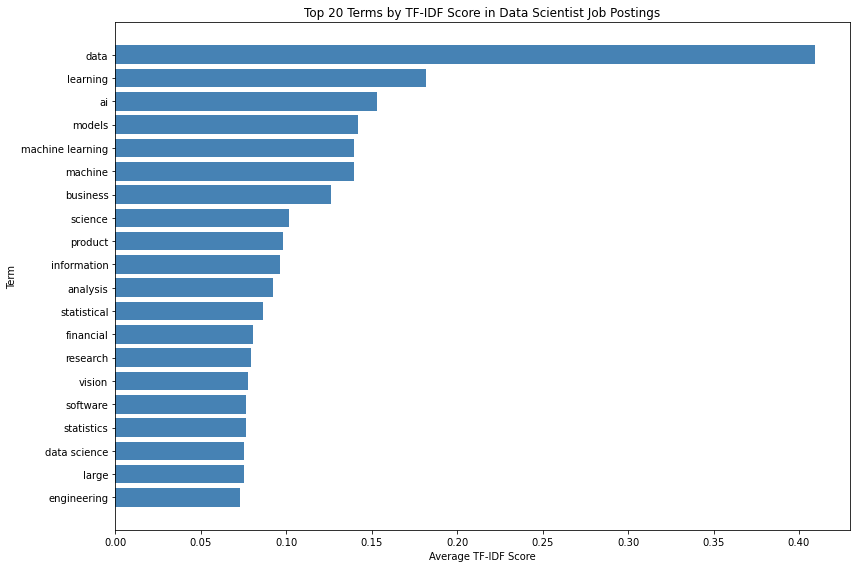

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_terms = tfidf_results.head(20)
plt.barh(range(len(top_terms)), top_terms['score'].values, color='steelblue')  
plt.yticks(range(len(top_terms)), top_terms['term'].values)
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.title('Top 20 Terms by TF-IDF Score in Data Scientist Job Postings')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Apriori Association Rule Mining 

In [75]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

noise_terms = ['ca', 'san', 'model', 'inc', 'jose', 'santa', 'clara', 'area', 
               'product', 'business', 'information', 'large', 'financial',
               'learning'] 

top_terms_list = [t for t in tfidf_results.head(15)['term'].tolist() if t not in noise_terms]
print(f"Using {len(top_terms_list)} terms: {top_terms_list}")

transactions = []
for doc in documents:
    doc_lower = doc.lower()
    found_terms = [term for term in top_terms_list if term in doc_lower]
    if found_terms:
        transactions.append(found_terms)

print(f"Transactions: {len(transactions)}")

te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.5, use_colnames=True)
print(f"Frequent itemsets: {len(frequent_itemsets)}")

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
multi_item = frequent_itemsets[frequent_itemsets['length'] >= 2].sort_values('support', ascending=False)

print("\nTop Skill Combinations")
for idx, row in multi_item.head(10).iterrows():
    skills = ' + '.join(sorted(row['itemsets']))
    print(f"{skills:45} | Support: {row['support']:.1%}")

# Association rules 
if len(frequent_itemsets) < 500:
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    rules = rules.sort_values('confidence', ascending=False)
    
    print("\nAssociation Rules")
    for idx, row in rules.head(10).iterrows():
        ant = ', '.join(sorted(row['antecedents']))
        con = ', '.join(sorted(row['consequents']))
        print(f"{ant} => {con}")
        print(f"    Confidence: {row['confidence']:.1%}, Support: {row['support']:.1%}")
else:
    print(f"\nToo many itemsets ({len(frequent_itemsets)}) - increase min_support")

Using 10 terms: ['data', 'ai', 'models', 'machine learning', 'machine', 'science', 'analysis', 'statistical', 'research', 'vision']
Transactions: 15
Frequent itemsets: 115

Top Skill Combinations
ai + data                                     | Support: 93.3%
ai + models                                   | Support: 93.3%
data + models                                 | Support: 86.7%
ai + data + models                            | Support: 86.7%
ai + machine learning + models                | Support: 80.0%
machine learning + models                     | Support: 80.0%
ai + machine + machine learning               | Support: 80.0%
machine + models                              | Support: 80.0%
machine + machine learning                    | Support: 80.0%
ai + machine + machine learning + models      | Support: 80.0%

Association Rules
data, machine, science => ai, models
    Confidence: 100.0%, Support: 53.3%
analysis, machine, machine learning => ai
    Confidence: 100.0%, Support: 60.0

/Users/fyonaluu/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in true_divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Visualize Top Skill Combinations

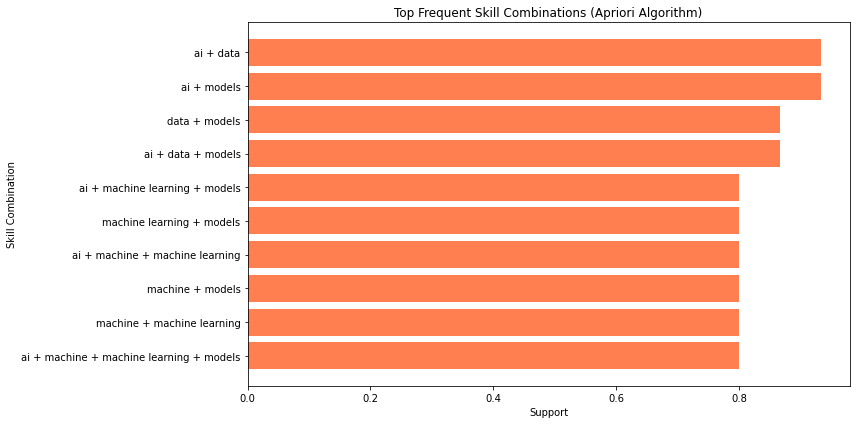

In [ ]:
# Visualize top skill combinations
if len(multi_item) > 0:
    plot_data = multi_item.head(10).copy()
    plot_data['skills'] = plot_data['itemsets'].apply(lambda x: ' + '.join(sorted(x)))
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(plot_data)), plot_data['support'].values, color='coral')
    plt.yticks(range(len(plot_data)), plot_data['skills'].values)
    plt.xlabel('Support')
    plt.ylabel('Skill Combination')
    plt.title('Top Frequent Skill Combinations (Apriori Algorithm)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

<h3>Low-Level Skillsets</h3>

Bag of Words Creation

In [78]:
N = 50
filtered_vocabulary = tfidf_results['term'].tolist()

import re
import pandas as pd
import time
import random

# --- List of all relevant headers to look for ---
HEADER_PHRASES = [
    'Minimum Qualifications', 'Qualifications', 'Requirements', 'What You Bring',
    'Key Responsibilities', 'Responsibilities', 'Job Duties', 'Your Role'
]

# Map multiple phrases to single standardized column names
NORMALIZED_KEYS = {
    'QUALIFICATIONS': 'Qualifications', 
    'REQUIREMENTS': 'Qualifications', 
    'MINIMUM QUALIFICATIONS': 'Qualifications',
    'MINIMUM REQUIREMENTS': 'Qualifications',
    'WHAT YOU BRING': 'Qualifications',
    'KEY RESPONSIBILITIES': 'Responsibilities', 
    'RESPONSIBILITIES': 'Responsibilities',
    'JOB DUTIES': 'Responsibilities',
    'YOUR ROLE': 'Responsibilities',
}

def extract_key_terms_by_header(description_text):
    """
    Finds key section headers in the description and extracts the content 
    that immediately follows until the next header or the end of the text.
    """
    extracted_sections = {}
    
    if not description_text or description_text == 'N/A' or description_text.startswith('BLOCKED'):
        return extracted_sections

    # Regex to find the headers, match the header text
    # The '|' joins the headers to search for any of them.
    HEADER_PATTERN = r'(' + '|'.join([re.escape(h) for h in HEADER_PHRASES]) + r')\s*:?\s*\n'
    
    # Use finditer to find the start and end positions of all headers
    matches = list(re.finditer(HEADER_PATTERN, description_text, re.IGNORECASE))
    
    if not matches:
        return extracted_sections

    for i, match in enumerate(matches):
        # The raw header text (e.g., 'Key Responsibilities')
        header_text = match.group(1).upper().strip() 
        start_index = match.end() # Start capturing content AFTER the header match

        # Determine the end of the section (start of the next header or end of document)
        if i + 1 < len(matches):
            end_index = matches[i+1].start()
        else:
            end_index = len(description_text)
            
        content = description_text[start_index:end_index].strip()
        
        # Normalize the header name
        normalized_key = next((v for k, v in NORMALIZED_KEYS.items() if k in header_text), None)

        if normalized_key and content and len(content) > 10:
            # If the key already exists (e.g., both "Qualifications" and "Requirements" are present), join the content
            if normalized_key in extracted_sections:
                extracted_sections[normalized_key] += "\n\n" + content
            else:
                extracted_sections[normalized_key] = content

    return extracted_sections


# Main Loop to Populate the new DataFrame

df = pd.DataFrame(all_jobs)
# df = df[~df['Description'].str.startswith('REQUEST ERROR', na=False)]

key_terms_list = []

# Assuming 'all_jobs' is the list of dictionaries containing 'Title', 'Link', and 'Description'
for index, row in df.iterrows():
    # 1. Extract the sections from the description text
    
    description = row['Description']
    extracted_sections = extract_key_terms_by_header(description)
    
    
    # 2. Create a new dictionary entry for the key_terms DataFrame
    key_terms_entry = {
        'Title': row['Title'],        
        'Link': row['Link'],
        'Qualifications': extracted_sections.get('Qualifications', ''),
        'Responsibilities': extracted_sections.get('Responsibilities', ''),
    }
    
    key_terms_list.append(key_terms_entry)

key_terms_df = pd.DataFrame(key_terms_list)

key_terms_df


,Title,Link,Qualifications,Responsibilities
0,Data Scientist,https://www.indeed.com/rc/clk?jk=78e6280457103...,"Bachelor’s or Master’s in Computer Science, St...",Assist in cleaning and preprocessing structure...
1,Data Scientist,https://www.indeed.com/rc/clk?jk=a4f3e98fa98cb...,"Bachelor’s or Master’s in Computer Science, St...",Assist in cleaning and preprocessing structure...
2,Data Scientist,https://www.indeed.com/viewjob?jk=cdef01234567...,,
3,Data Scientist (Tapestry),https://www.indeed.com/rc/clk?jk=8bb8e7ae29b53...,,
4,"Research Scientist, Foundation Model (LLM)",https://www.indeed.com/rc/clk?jk=780362905ef9d...,"1. Excellent coding ability, data structures, ...",With a long-term vision and a strong commitmen...
5,Data Scientist,https://www.indeed.com/rc/clk?jk=2ad5b66e52509...,Self-starter with good communication skills\nP...,Extract data from multiple data sources like M...
6,"Data Scientist (Dublin, CA)",https://www.indeed.com/rc/clk?jk=f33e369c31172...,,Perform exploratory and statistical data analy...
7,Machine Learning Engineer,https://www.indeed.com/rc/clk?jk=54d0e2fb38ac1...,,"Design, develop, and implement machine learnin..."
8,Data Scientist,https://www.indeed.com/rc/clk?jk=18dd050faef8e...,"Bachelor’s or Master’s in Computer Science, Da...",Design and implement ETL/ELT pipelines using D...
9,Machine Learning Engineer,https://www.indeed.com/rc/clk?jk=674087e716231...,,


Run TFIDF once to retrieve high-level words

In [79]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Custom stop words for job postings
custom_stop_words = [
    'job', 'jobs', 'experience', 'skills', 'skill', 'work', 'working',
    'description', 'job description', 'nbsp', 'team', 'time', 'company',
    'role', 'position', 'years', 'year', 'ability', 'strong', 'good',
    'excellent', 'required', 'preferred', 'looking', 'seeking', 'apply',
    'candidate', 'candidates', 'qualifications', 'requirements', 'responsibilities',
    'profile', 'insights', 'find', 'align', 'yes', 'no', 'details', 'type',
    'full', 'based', 'including', 'using', 'used', 'new', 'like', 'etc', 'sajix', 
    'healthcare', 'insurance', '000', 'paid', 'range', 'solutions', 'knowledge'
]
all_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

# Load data from JSON
with open('indeed_job_data_sample.json', 'r') as f:
    all_jobs = json.load(f)

df = pd.DataFrame(all_jobs)
df = df[~df['Description'].str.startswith('REQUEST ERROR', na=False)]
print(f"Loaded {len(df)} valid records")

# Use full Description column
documents = df['Description'].tolist()
print(f"Documents for TF-IDF: {len(documents)}")

# TF-IDF Analysis with custom stop words
vectorizer = TfidfVectorizer(
    max_features=50,
    stop_words=all_stop_words,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()
scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Results
tfidf_results = pd.DataFrame({'term': terms, 'score': scores})
tfidf_results = tfidf_results.sort_values('score', ascending=False)
print("\nTop 20 Important Terms:")
print(tfidf_results.head(20).to_string(index=False))

Loaded 15 valid records
Documents for TF-IDF: 15

Top 20 Important Terms:
            term    score
            data 0.409133
        learning 0.181775
              ai 0.153160
          models 0.142062
machine learning 0.139324
         machine 0.139324
        business 0.125942
         science 0.101758
         product 0.097942
     information 0.096195
        analysis 0.092129
     statistical 0.086186
       financial 0.080343
        research 0.079058
          vision 0.077372
        software 0.076521
      statistics 0.076183
    data science 0.075250
           large 0.075135
     engineering 0.072675


In [43]:
# %pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [nltk]3/4 [nltk]
Note: you may need to restart the kernel to use updated packages.


In [80]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

# Tokenizes the document and steps each token
def stemmed_words(doc):
    temp_vectorizer = TfidfVectorizer()
    analyzer = temp_vectorizer.build_analyzer()
    return (stemmer.stem(w) for w in analyzer(doc))

# remove the previous run's high level skills as stop words
generic_context_words = tfidf_results.head(20)['term'].tolist()

# remove the non-technical skill words
nontechnical_words = [
    'stakeholders', 'research', 'support', 'teams', 'communication', 'development', 
    'design', 'production', 'exploratory', 'model', 'assist', 'explore', 'participate',
    'tools', 'document', 'computer', 'partner', 'advanced', 'opportunities', 'program',
    'roles', 'practical'
]

# Custom stop words for job postings
custom_stop_words = [
    'job', 'jobs', 'experience', 'skills', 'skill', 'work', 'working',
    'description', 'job description', 'nbsp', 'team', 'time', 'company',
    'role', 'position', 'years', 'year', 'ability', 'strong', 'good',
    'excellent', 'required', 'preferred', 'looking', 'seeking', 'apply',
    'candidate', 'candidates', 'qualifications', 'requirements', 'responsibilities',
    'profile', 'insights', 'find', 'align', 'yes', 'no', 'details', 'type',
    'full', 'based', 'including', 'using', 'used', 'new', 'like', 'etc', 'sajix', 
    'healthcare', 'insurance', '000', 'paid', 'range', 'solutions', 'knowledge',
    'expertise', 'generation', 'salary', 'technical', 'present', 'findings', 'spark',
    'status', 'similar','non', 'collaboration', 'additional', 'learn', 'com'
]
all_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words + generic_context_words + nontechnical_words
# stemmed_stop_words = [stemmer.stem(word) for word in all_stop_words]

# Load data from JSON
with open('indeed_job_data_sample.json', 'r') as f:
    all_jobs = json.load(f)

new_df = pd.DataFrame(all_jobs)

# Use Qualifications & Requirements column
qual = key_terms_df['Qualifications'].tolist()
resp = key_terms_df['Responsibilities'].tolist()

new_documents = qual + resp

# # Use full Description column
# documents = df['Description'].tolist()
# print(f"Documents for TF-IDF: {len(documents)}")

# TF-IDF Analysis with custom stop words
new_vectorizer = TfidfVectorizer(
    max_features=400,
    stop_words=all_stop_words,
    ngram_range=(1, 1),
    min_df=1,
)

new_tfidf_matrix = new_vectorizer.fit_transform(new_documents)
new_terms = new_vectorizer.get_feature_names_out()
new_scores = np.asarray(new_tfidf_matrix.mean(axis=0)).flatten()

# Results
new_tfidf_results = pd.DataFrame({'term': new_terms, 'score': new_scores})
new_tfidf_results = new_tfidf_results.sort_values('score', ascending=False)
print("\nTop 20 Important Terms (Low-Level):")
print(new_tfidf_results.head(20).to_string(index=False))


Top 20 Important Terms (Low-Level):
         term    score
   structured 0.035858
       python 0.035481
 unstructured 0.032236
   databricks 0.031575
          sql 0.031282
     cleaning 0.030108
preprocessing 0.030108
      feature 0.029739
   tensorflow 0.029166
reinforcement 0.024575
         deep 0.021944
      tableau 0.021697
   frameworks 0.019868
   __init__py 0.019661
   algorithms 0.018733
    libraries 0.018295
          phd 0.018196
   processing 0.017920
        azure 0.017531
       pandas 0.017406


In [61]:
# %pip install matplotlib
# %pip install mlxtend

  Using cached matplotlib-3.10.7-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-macosx_10_13_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_10_13_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-12.0.0-cp312-cp312-macosx_10_13_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp312-cp312-macosx_10_13_x86_64.whl (8.3 MB)
Using cached contourpy-1.3.3-cp312-cp312-macosx_10_13_x86_64.whl (293 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 6.8 MB/s  0:00:00m eta 0:00:01
Using cached kiwisolver-1.4.9-cp312-cp312-macosx_10_13_x86_64.whl (66 kB)
Using cached pillow-12.0.0-cp312-cp312-macosx_10_13_x86_64.whl (5.2 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Re-Evaluate the Low-Level Terms

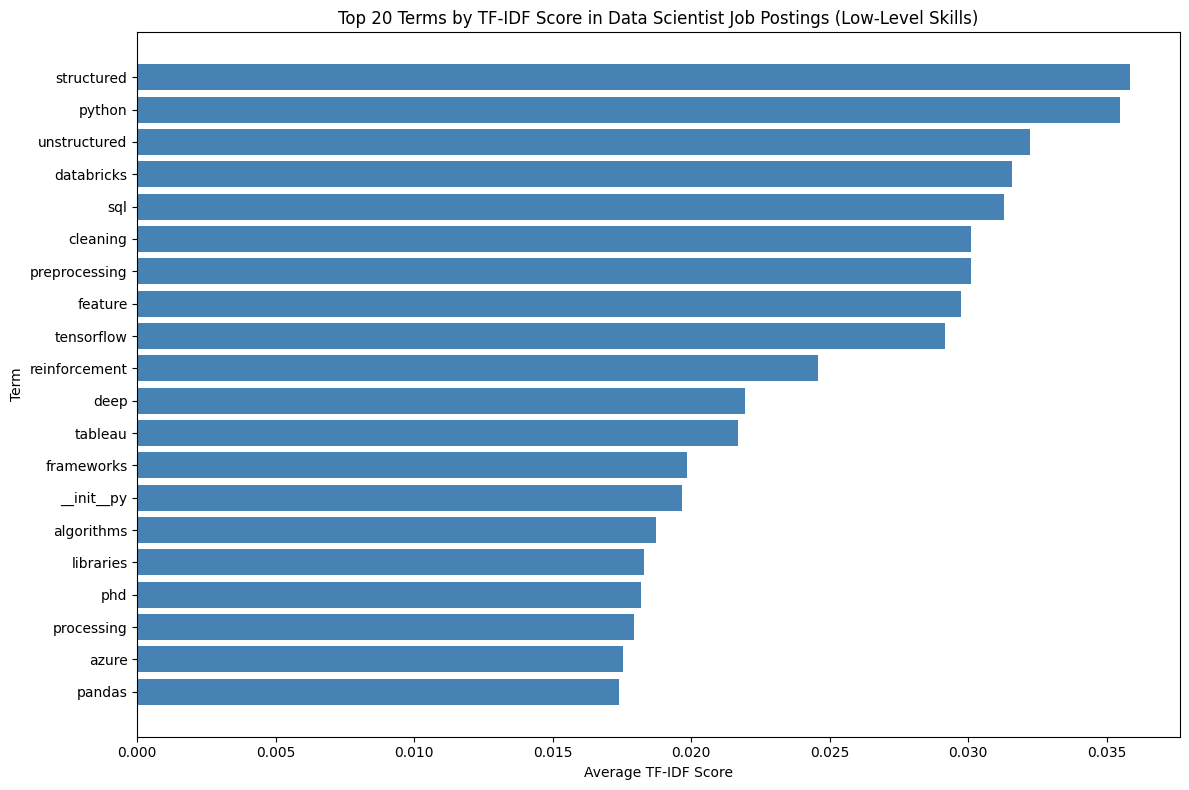

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_terms = new_tfidf_results.head(20)
plt.barh(range(len(top_terms)), top_terms['score'].values, color='steelblue')  
plt.yticks(range(len(top_terms)), top_terms['term'].values)
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.title('Top 20 Terms by TF-IDF Score in Data Scientist Job Postings (Low-Level Skills)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Apriori Association Rule Mining (Low-Level)

In [82]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

new_noise_terms = ['ca', 'san', 'model', 'inc', 'jose', 'santa', 'clara', 'area', 
               'product', 'business', 'information', 'large', 'financial',
               'learning'] 

new_top_terms_list = [t for t in new_tfidf_results.head(15)['term'].tolist() if t not in new_noise_terms]
print(f"Using {len(new_top_terms_list)} terms: {new_top_terms_list}")

new_transactions = []
for doc in documents:
    doc_lower = doc.lower()
    found_terms = [term for term in new_top_terms_list if term in doc_lower]
    if found_terms:
        new_transactions.append(found_terms)

print(f"Transactions: {len(new_transactions)}")

new_te = TransactionEncoder()
new_te_array = new_te.fit_transform(new_transactions)
new_df_encoded = pd.DataFrame(new_te_array, columns=new_te.columns_)

new_frequent_itemsets = apriori(new_df_encoded, min_support=0.2, use_colnames=True)
print(f"Frequent itemsets: {len(new_frequent_itemsets)}")

new_frequent_itemsets['length'] = new_frequent_itemsets['itemsets'].apply(len)
new_multi_item = new_frequent_itemsets[new_frequent_itemsets['length'] >= 2].sort_values('support', ascending=False)

print("\nTop Skill Combinations")
for idx, row in new_multi_item.head(10).iterrows():
    skills = ' + '.join(sorted(row['itemsets']))
    print(f"{skills:45} | Support: {row['support']:.1%}")

# Association rules 
if len(new_frequent_itemsets) < 500:
    rules = association_rules(new_frequent_itemsets, metric="confidence", min_threshold=0.6)
    rules = rules.sort_values('confidence', ascending=False)
    
    print("\nAssociation Rules")
    for idx, row in rules.head(10).iterrows():
        ant = ', '.join(sorted(row['antecedents']))
        con = ', '.join(sorted(row['consequents']))
        print(f"{ant} => {con}")
        print(f"    Confidence: {row['confidence']:.1%}, Support: {row['support']:.1%}")
else:
    print(f"\nToo many itemsets ({len(new_frequent_itemsets)}) - increase min_support")

Using 15 terms: ['structured', 'python', 'unstructured', 'databricks', 'sql', 'cleaning', 'preprocessing', 'feature', 'tensorflow', 'reinforcement', 'deep', 'tableau', 'frameworks', '__init__py', 'algorithms']
Transactions: 15
Frequent itemsets: 48

Top Skill Combinations
python + sql                                  | Support: 66.7%
algorithms + python                           | Support: 40.0%
deep + python                                 | Support: 40.0%
feature + python                              | Support: 40.0%
python + tensorflow                           | Support: 26.7%
algorithms + python + sql                     | Support: 26.7%
deep + python + sql                           | Support: 26.7%
python + unstructured                         | Support: 26.7%
algorithms + feature + python                 | Support: 26.7%
frameworks + python                           | Support: 26.7%

Association Rules
algorithms, sql => python
    Confidence: 100.0%, Support: 26.7%
python, table

Visualize Top Skill Combinations (Low-Level)

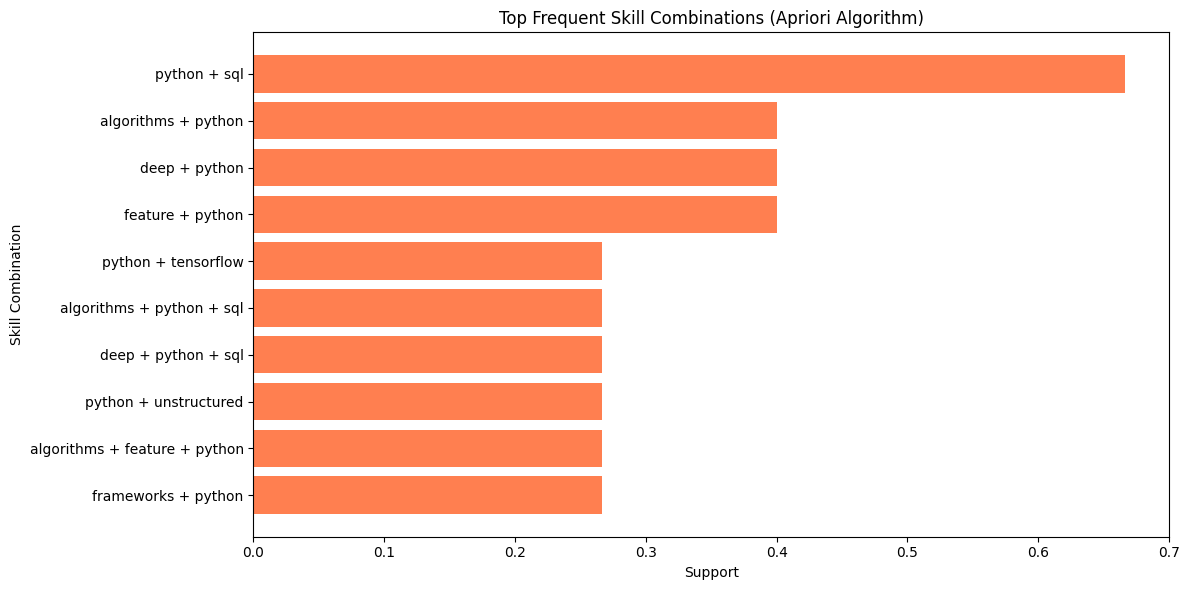

In [83]:
# Visualize top skill combinations
if len(new_multi_item) > 0:
    plot_data = new_multi_item.head(10).copy()
    plot_data['skills'] = plot_data['itemsets'].apply(lambda x: ' + '.join(sorted(x)))
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(plot_data)), plot_data['support'].values, color='coral')
    plt.yticks(range(len(plot_data)), plot_data['skills'].values)
    plt.xlabel('Support')
    plt.ylabel('Skill Combination')
    plt.title('Top Frequent Skill Combinations (Apriori Algorithm)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()